# 06 - CNN models - RESNET50

In this notebook, we are going to do CNN model (with transfer Learning from resnet50).

(Also gonna work with a sample of our dataset to be able to evaluate faster the results.
Our sample is gonna be equalized/normalized by the classes, an equal amount for each class)

### Steps: 
 - Importing/accessing the data
 - Separating the Train and Test Data
 - Fitting the model(Resnet -> working with 3 channels)
 - Evaluate the model
    - Accuracy, Precision, Recall, f1  .....  Confusion Matrix 
 - Using the model to predict the specifics images

## Importing/accessing the data

First, importing the libs and treating the data:

In [16]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset_directory = '../datasets/dataset_normal/'

# Load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for label, folder in enumerate(os.listdir(directory)):
        for filename in os.listdir(os.path.join(directory, folder)):
            img = cv2.imread(os.path.join(directory, folder, filename))
            img = cv2.resize(img, (100, 100))  # Resize image
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img.flatten())  # Flatten image
            labels.append(label)
    return np.array(images), np.array(labels)

# Feature extraction
images, labels = load_images(dataset_directory)

# Feature scaling (optional but recommended)
images = images / 255.0  # Scale pixel values to range [0, 1]


In [17]:
# Sanity Check
images.shape
# labels

(17092, 30000)

## Separeting the Train and Test Data

Spliting data into training and testing sets

In [18]:
# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.6, test_size=0.2, stratify=labels, random_state=42)


In [19]:
print(X_train.shape)
print(y_train.shape)
# print(y_train)
print(X_test.shape)
print(y_train.shape)

(10255, 30000)
(10255,)
(3419, 30000)
(10255,)


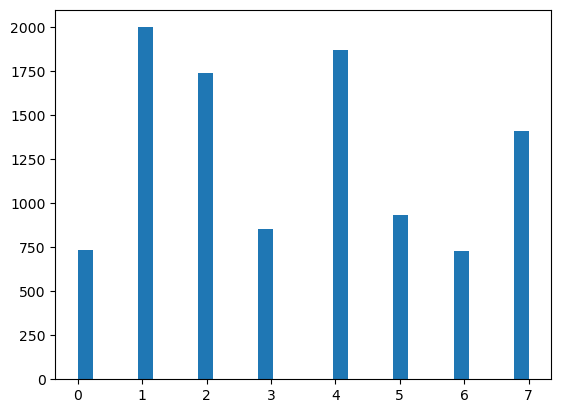

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_train, bins=30)
plt.show()

In [21]:
from sklearn.utils import resample

# Calculate the size of the smallest class
min_class_size = min(np.bincount(y_train))

# Undersampling majority classes to match the size of the minority class
X_train_balanced = []
y_train_balanced = []
for i in range(8):  # Assuming you have 8 classes
    X_class_i = X_train[y_train == i]
    y_class_i = y_train[y_train == i]
    X_class_i_resampled, y_class_i_resampled = resample(X_class_i, y_class_i, n_samples=min_class_size, random_state=42)
    X_train_balanced.append(X_class_i_resampled)
    y_train_balanced.append(y_class_i_resampled)

X_train_balanced = np.concatenate(X_train_balanced)
y_train_balanced = np.concatenate(y_train_balanced)

# #-------------------------
# # Oversampling minority classes to match the size of the majority class
# # You can use techniques like SMOTE for better synthetic sampling
# # Here, I'm just duplicating existing samples
# X_train_balanced_oversampled = []
# y_train_balanced_oversampled = []
# for i in range(8):  # Assuming you have 8 classes
#     X_class_i = X_train[y_train == i]
#     y_class_i = y_train[y_train == i]
#     X_class_i_oversampled, y_class_i_oversampled = resample(X_class_i, y_class_i, n_samples=len(X_train_balanced), random_state=42)
#     X_train_balanced_oversampled.append(X_class_i_oversampled)
#     y_train_balanced_oversampled.append(y_class_i_oversampled)

# X_train_balanced_oversampled = np.concatenate(X_train_balanced_oversampled)
# y_train_balanced_oversampled = np.concatenate(y_train_balanced_oversampled)


In [22]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)
# print(y_train)


(5824, 30000)
(5824,)


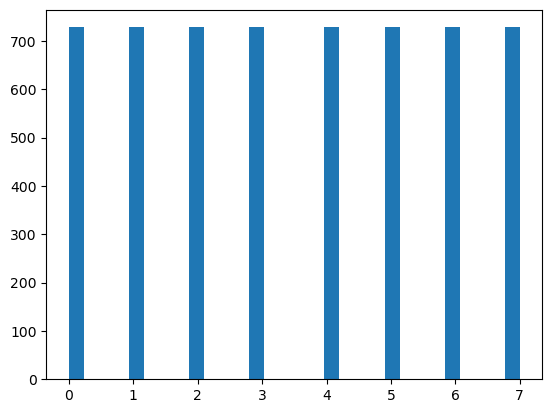

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_train_balanced, bins=30)
plt.show()

## Training the model (train the logistic regression)

Training/fiting the models

In [24]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Resnet-50

In [25]:
#import the base model -> resnet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications import ResNet50V2

res_model = ResNet50V2(
    # weights='imagenet',
    include_top=False,
    input_shape=(100,100,3)
)
res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 52, 52, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [26]:
# Freeze all the layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow import keras

# Adding more layers
x = res_model.output
x = Flatten()(x) 
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(8, activation='softmax')(x)

#---------------
# Binding both 'models'
model = Model(inputs=res_model.input, 
              outputs=output)

model.summary()


In [ ]:
# Defining the optimizer, loss and metrics
# set_random_seed(121)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3,
                           mode='min', 
                           verbose=1)


In [28]:
from tensorflow.keras.utils import to_categorical

# Reshape flattened input data back to images
X_train_images = X_train_balanced.reshape(-1, 100, 100, 3)
X_test_images = X_test.reshape(-1, 100, 100, 3)

# y_train_balanced contains target labels
# Converting target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_balanced, num_classes=8)
y_test_encoded = to_categorical(y_test, num_classes=8)

In [15]:

# Training the model
history = model.fit(
    X_train_images,
    y_train_encoded,
          epochs=10,
    validation_data=(X_test_images, y_test_encoded),
          # callbacks=[early_stop]
         )

Epoch 1/10


2024-04-12 08:05:09.301295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


181/182 [============================>.] - ETA: 0s - loss: 16.7284 - accuracy: 0.3189

2024-04-12 08:05:19.734652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 17s 73ms/step - loss: 16.6667 - accuracy: 0.3185 - val_loss: 5.2365 - val_accuracy: 0.3542
Epoch 2/10
182/182 [==============================] - 11s 60ms/step - loss: 5.3022 - accuracy: 0.3666 - val_loss: 4.4859 - val_accuracy: 0.3422
Epoch 3/10
182/182 [==============================] - 11s 61ms/step - loss: 3.5991 - accuracy: 0.4660 - val_loss: 3.9263 - val_accuracy: 0.5039
Epoch 4/10
182/182 [==============================] - 11s 62ms/step - loss: 2.5100 - accuracy: 0.5780 - val_loss: 2.8775 - val_accuracy: 0.5303
Epoch 5/10
182/182 [==============================] - 12s 64ms/step - loss: 1.9436 - accuracy: 0.6228 - val_loss: 4.5167 - val_accuracy: 0.4785
Epoch 6/10
182/182 [==============================] - 11s 60ms/step - loss: 2.7191 - accuracy: 0.6156 - val_loss: 3.4935 - val_accuracy: 0.5344
Epoch 7/10
182/182 [==============================] - 11s 60ms/step - loss: 3.4462 - accuracy: 0.6190 - val_loss: 3.2358 - val_accuracy: 0.6043
Ep

In [16]:
# Evaluate the model's performance on the test data
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 4s 34ms/step - loss: 2.0229 - accuracy: 0.6794
Test loss: 2.022876024246216
Test accuracy: 0.6794384121894836


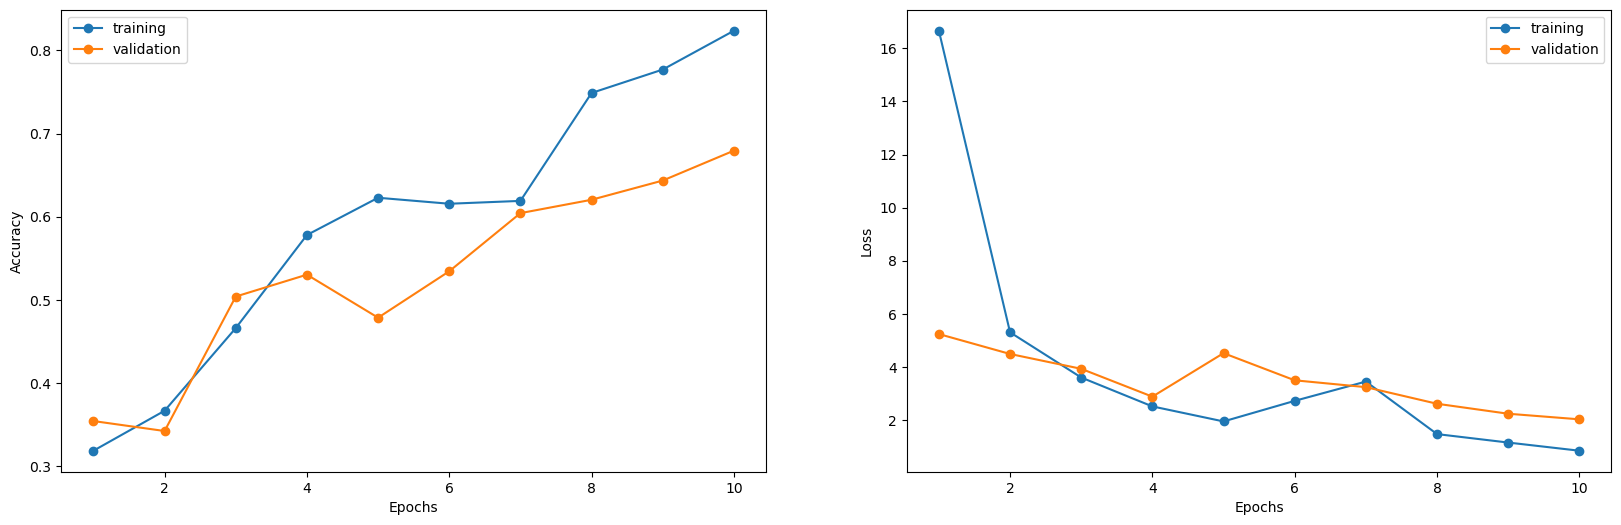

In [17]:
epochs = range(1, 11)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
# #Training with the best epochs

# # Training the model
history = model.fit(
    X_train_images,
    y_train_encoded,
          epochs=7,
    validation_data=(X_test_images, y_test_encoded),
          # callbacks=[early_stop]
         )

Epoch 1/7


2024-04-12 10:22:17.775520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - ETA: 0s - loss: 23.6130 - accuracy: 0.2615

2024-04-12 10:22:27.974548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 16s 79ms/step - loss: 23.6130 - accuracy: 0.2615 - val_loss: 7.4170 - val_accuracy: 0.3589
Epoch 2/7
182/182 [==============================] - 11s 58ms/step - loss: 6.8058 - accuracy: 0.3721 - val_loss: 4.5228 - val_accuracy: 0.4384
Epoch 3/7
182/182 [==============================] - 11s 59ms/step - loss: 3.2255 - accuracy: 0.4930 - val_loss: 3.0540 - val_accuracy: 0.4785
Epoch 4/7
182/182 [==============================] - 11s 60ms/step - loss: 2.7378 - accuracy: 0.5306 - val_loss: 2.7221 - val_accuracy: 0.5382
Epoch 5/7
182/182 [==============================] - 11s 59ms/step - loss: 2.4735 - accuracy: 0.5704 - val_loss: 2.8005 - val_accuracy: 0.5373
Epoch 6/7
182/182 [==============================] - 11s 59ms/step - loss: 2.1058 - accuracy: 0.6073 - val_loss: 2.1732 - val_accuracy: 0.5639
Epoch 7/7
182/182 [==============================] - 11s 60ms/step - loss: 1.7161 - accuracy: 0.6411 - val_loss: 1.9755 - val_accuracy: 0.5850


In [30]:
# # Checking the model's performance to ensure
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 4s 34ms/step - loss: 1.9755 - accuracy: 0.5850
Test loss: 1.9755429029464722
Test accuracy: 0.5849663615226746


## Evaluete the model

Seeing how the model peform with the train and test data:

### Accuracy, Precision, Recall, f1

Getting Accuracy, Precision, Recall and f1 from the model and seeing in each class

In [31]:
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 4s 35ms/step - loss: 1.9755 - accuracy: 0.5850
Test loss: 1.9755429029464722
Test accuracy: 0.5849663615226746


In [32]:
# Predicting
y_score = model.predict(X_test_images)

2024-04-12 10:23:47.297247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


107/107 [==============================] - 4s 35ms/step


In [33]:
# ONE-HOT ENCODE
# Convert probabilities to label encoding
y_predict = np.argmax(y_score, axis=1)

# Convert one-hot encoded labels to class labels for y_test
y_test_labels = np.argmax(y_test_encoded, axis=1)


In [34]:
# Sanity check on the encode
accuracy = accuracy_score(y_test_labels, y_predict)
print("Accuracy:", accuracy)

Accuracy: 0.584966364434045


In [35]:
# ONE-HOT ENCODE
# Convert probabilities to label encoding
y_predict = np.argmax(y_score, axis=1)

# Convert one-hot encoded labels to class labels for y_test
y_test_labels = np.argmax(y_test_encoded, axis=1)


In [37]:
from sklearn.metrics import classification_report

# Generate classification report
report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

              precision    recall  f1-score   support

           0       0.27      0.60      0.37       243
           1       0.66      0.68      0.67       666
           2       0.53      0.20      0.29       579
           3       0.43      0.72      0.54       284
           4       0.71      0.61      0.65       624
           5       0.51      0.61      0.55       310
           6       0.79      0.40      0.53       243
           7       0.90      0.88      0.89       470

    accuracy                           0.58      3419
   macro avg       0.60      0.59      0.56      3419
weighted avg       0.63      0.58      0.58      3419



### Confusion Matrix 

Plotting the confusion Matrix (as a porcentage) and observate the classification from the model

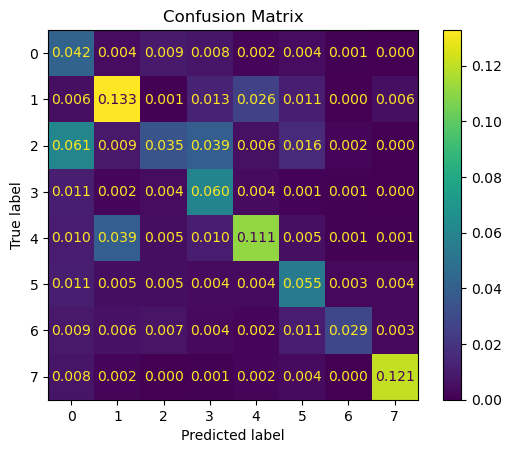

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_labels, y_predict, normalize='all', values_format='.3f')
plt.title('Confusion Matrix')
plt.show()


In [39]:
cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

## Using the model to predict the specifics images

In [ ]:
# Load the model 

# logreg = joblib.load('../models/logistic_regression_model.pkl')
# result = logreg.score(X_test, y_test)
# print(result)

In [197]:
# filename = '../datasets/dataset_normal/basophil/BA_47.jpg'
# filename = '../datasets/dataset_normal/neutrophil/BNE_715.jpg'
filename = '../datasets/dataset_normal/neutrophil/BNE_840.jpg'

img = cv2.imread(os.path.join(filename))
img = cv2.resize(img, (100, 100))  # Resize image
images = img.flatten()  # Flatten image

result = model.predict(image)
print(np.argmax(result))

print(f"The cell that was detect was: {cells[np.argmax(result)]}")

5
The cell that was detect was: monocyte
